In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333 and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [00:05<00:00, 1853.12it/s]


10391

In [2]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10391, (90948,))

In [3]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
standard = StandardScaler()
adjusted_recordings = standard.fit_transform(adjusted_recordings)
print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




[[-3.91315894e-03 -2.08178719e-03  7.07403015e-03 ...  3.97710492e-02
   3.89222529e-02  3.43722279e-02]
 [ 2.54340067e-01  3.18888249e-01  5.00963191e-01 ... -3.15180136e-01
  -2.67018609e-01 -1.80737937e-01]
 [-1.11767359e-03 -2.09454250e-03 -2.72278684e-04 ...  1.59298169e-02
   9.39241865e-03 -2.23828698e-03]
 ...
 [ 2.27792832e-01  2.35611148e-01  2.11838498e-01 ...  6.82101747e-02
   5.28060648e-02  1.46057692e-02]
 [-3.71829769e-03 -1.78789066e-03 -1.21324795e-03 ...  8.64892466e-02
  -1.11829173e-01 -1.93425859e-01]
 [-2.01032000e-01 -3.58533093e-01 -1.35592739e-01 ... -3.44990583e+00
  -3.14912292e+00 -2.65295907e+00]]


In [5]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([6234, 1, 90948]), torch.Size([6234]))

In [6]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=44100,      ## 44.1 kHz
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(564,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
            
        

        


In [7]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=50)

c:\Users\20211922\Documents\DeepL\DL_ASSIGNMENT\.venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
  2%|▏         | 1/50 [00:20<16:21, 20.04s/it]

Epoch [1/50], Loss: 10.3925
--------------------------------------------------


  4%|▍         | 2/50 [00:29<10:58, 13.73s/it]

Epoch [2/50], Loss: 1.2386
--------------------------------------------------
Epoch [3/50], Loss: 0.9808


  6%|▌         | 3/50 [00:39<09:27, 12.08s/it]

Mean Squared Error: 0.8299 and Mean Absolute Error: 0.7171
None
--------------------------------------------------
Epoch [4/50], Loss: 0.8644


  8%|▊         | 4/50 [00:49<08:39, 11.30s/it]

Mean Squared Error: 0.8165 and Mean Absolute Error: 0.7047
None
--------------------------------------------------
Epoch [5/50], Loss: 0.7658


 10%|█         | 5/50 [00:59<08:06, 10.81s/it]

Mean Squared Error: 0.7843 and Mean Absolute Error: 0.7215
None
--------------------------------------------------
Epoch [6/50], Loss: 0.7545


 12%|█▏        | 6/50 [01:09<07:42, 10.50s/it]

Mean Squared Error: 0.6891 and Mean Absolute Error: 0.6682
None
--------------------------------------------------
Epoch [7/50], Loss: 0.6966


 14%|█▍        | 7/50 [01:19<07:21, 10.28s/it]

Mean Squared Error: 0.7636 and Mean Absolute Error: 0.6883
None
--------------------------------------------------
Epoch [8/50], Loss: 0.6725


 16%|█▌        | 8/50 [01:29<07:06, 10.15s/it]

Mean Squared Error: 0.6513 and Mean Absolute Error: 0.6462
None
--------------------------------------------------
Epoch [9/50], Loss: 0.6546


 18%|█▊        | 9/50 [01:39<06:53, 10.09s/it]

Mean Squared Error: 0.6901 and Mean Absolute Error: 0.6787
None
--------------------------------------------------
Epoch [10/50], Loss: 0.6461


 20%|██        | 10/50 [01:48<06:40, 10.01s/it]

Mean Squared Error: 0.6338 and Mean Absolute Error: 0.6389
None
--------------------------------------------------
Epoch [11/50], Loss: 0.6205


 22%|██▏       | 11/50 [01:58<06:28,  9.95s/it]

Mean Squared Error: 0.6695 and Mean Absolute Error: 0.6530
None
--------------------------------------------------
Epoch [12/50], Loss: 0.6064


 24%|██▍       | 12/50 [02:08<06:16,  9.90s/it]

Mean Squared Error: 0.6201 and Mean Absolute Error: 0.6368
None
--------------------------------------------------
Epoch [13/50], Loss: 0.5907


 26%|██▌       | 13/50 [02:18<06:05,  9.87s/it]

Mean Squared Error: 0.6160 and Mean Absolute Error: 0.6419
None
--------------------------------------------------
Epoch [14/50], Loss: 0.6042


 28%|██▊       | 14/50 [02:28<05:55,  9.86s/it]

Mean Squared Error: 0.6129 and Mean Absolute Error: 0.6395
None
--------------------------------------------------
Epoch [15/50], Loss: 0.5821


 30%|███       | 15/50 [02:37<05:44,  9.84s/it]

Mean Squared Error: 0.5904 and Mean Absolute Error: 0.6197
None
--------------------------------------------------
Epoch [16/50], Loss: 0.5750


 32%|███▏      | 16/50 [02:47<05:34,  9.83s/it]

Mean Squared Error: 0.6218 and Mean Absolute Error: 0.6287
None
--------------------------------------------------
Epoch [17/50], Loss: 0.5842


 34%|███▍      | 17/50 [02:57<05:24,  9.82s/it]

Mean Squared Error: 0.5845 and Mean Absolute Error: 0.6127
None
--------------------------------------------------
Epoch [18/50], Loss: 0.5577


 36%|███▌      | 18/50 [03:07<05:14,  9.84s/it]

Mean Squared Error: 0.5753 and Mean Absolute Error: 0.6164
None
--------------------------------------------------
Epoch [19/50], Loss: 0.5588


 38%|███▊      | 19/50 [03:17<05:05,  9.84s/it]

Mean Squared Error: 0.5792 and Mean Absolute Error: 0.6193
None
--------------------------------------------------
Epoch [20/50], Loss: 0.5548


 40%|████      | 20/50 [03:27<04:55,  9.86s/it]

Mean Squared Error: 0.5691 and Mean Absolute Error: 0.6114
None
--------------------------------------------------
Epoch [21/50], Loss: 0.5394


 42%|████▏     | 21/50 [03:36<04:45,  9.84s/it]

Mean Squared Error: 0.5674 and Mean Absolute Error: 0.6060
None
--------------------------------------------------
Epoch [22/50], Loss: 0.5536


 44%|████▍     | 22/50 [03:46<04:35,  9.83s/it]

Mean Squared Error: 0.5811 and Mean Absolute Error: 0.6088
None
--------------------------------------------------
Epoch [23/50], Loss: 0.5435


 46%|████▌     | 23/50 [03:56<04:25,  9.83s/it]

Mean Squared Error: 0.5523 and Mean Absolute Error: 0.6007
None
--------------------------------------------------
Epoch [24/50], Loss: 0.5248


 48%|████▊     | 24/50 [04:06<04:15,  9.83s/it]

Mean Squared Error: 0.5488 and Mean Absolute Error: 0.6008
None
--------------------------------------------------
Epoch [25/50], Loss: 0.5429


 50%|█████     | 25/50 [04:16<04:05,  9.84s/it]

Mean Squared Error: 0.5673 and Mean Absolute Error: 0.6143
None
--------------------------------------------------
Epoch [26/50], Loss: 0.5318


 52%|█████▏    | 26/50 [04:26<03:56,  9.84s/it]

Mean Squared Error: 0.5490 and Mean Absolute Error: 0.6006
None
--------------------------------------------------
Epoch [27/50], Loss: 0.5132


 54%|█████▍    | 27/50 [04:35<03:46,  9.84s/it]

Mean Squared Error: 0.5477 and Mean Absolute Error: 0.5970
None
--------------------------------------------------
Epoch [28/50], Loss: 0.5225


 56%|█████▌    | 28/50 [04:45<03:36,  9.85s/it]

Mean Squared Error: 0.5588 and Mean Absolute Error: 0.6029
None
--------------------------------------------------
Epoch [29/50], Loss: 0.5235


 58%|█████▊    | 29/50 [04:55<03:27,  9.88s/it]

Mean Squared Error: 0.5446 and Mean Absolute Error: 0.5958
None
--------------------------------------------------
Epoch [30/50], Loss: 0.5161


 60%|██████    | 30/50 [05:05<03:16,  9.85s/it]

Mean Squared Error: 0.5458 and Mean Absolute Error: 0.5967
None
--------------------------------------------------
Epoch [31/50], Loss: 0.5145


 62%|██████▏   | 31/50 [05:15<03:07,  9.85s/it]

Mean Squared Error: 0.5489 and Mean Absolute Error: 0.6043
None
--------------------------------------------------
Epoch [32/50], Loss: 0.5257


 64%|██████▍   | 32/50 [05:25<02:57,  9.85s/it]

Mean Squared Error: 0.5416 and Mean Absolute Error: 0.5982
None
--------------------------------------------------


 64%|██████▍   | 32/50 [05:31<03:06, 10.36s/it]


KeyboardInterrupt: 

Mean Squared Error: 0.4633 and Mean Absolute Error: 0.5504


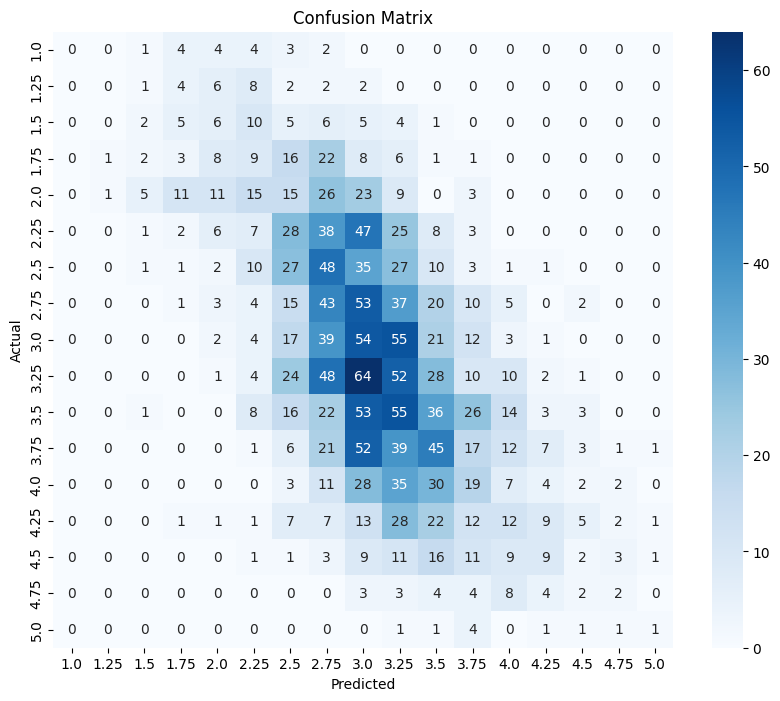

Accuracy: 0.1313


In [ ]:
evaluate_model(modelCNN, test_loader,conf=True)

Mean Squared Error: 0.3836 and Mean Absolute Error: 0.5005


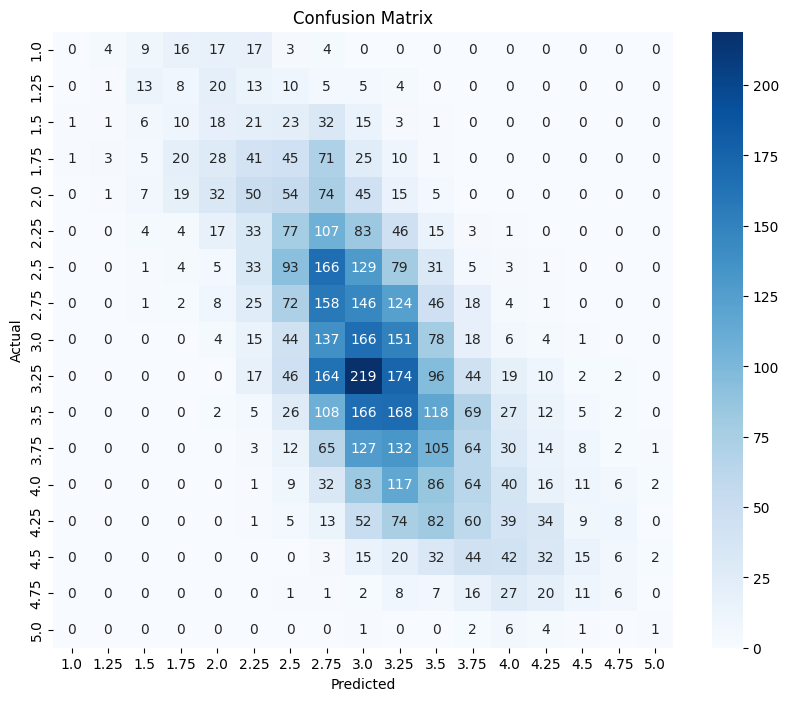

Accuracy: 0.1542


In [ ]:
evaluate_model(modelCNN, train_loader,conf=True)